<h1> Observations </h1>
<ol>
    <li> Sentiment of each tweet from the Media outlets is very random.  Not much dependency on the prior tweet. </li>
    <li> In general there were lot of neutral sentiment tweet from each Media outlet. </li>
    <li> New York Times and CNN had on an average more negetive sentiment compared to other Media outlets.</li>

</ol> 

In [1]:
# Dependencies
import tweepy
import numpy as np
import pandas as pd
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns

# Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Twitter API Keys
from config import (consumer_key, 
                    consumer_secret, 
                    access_token, 
                    access_token_secret)

# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [2]:
# Target Search Term
target_terms = ("@BBC", "@CBS", "@CNN",
                "@Fox", "@NewYorkTimes")




In [3]:
# List to hold results
results_list = []

# "Real Person" Filters
min_tweets = 5
max_tweets = 10000
max_followers = 2500
max_following = 2500
lang = "en"

# Loop through all target users
for target in target_terms:
    #variable to hold tweets ago
    tweet_ago = 0
    oldest_tweet = None
    if (tweet_ago < 100):
        # Loop through 20 times
        for x in range(20):

            # Run search around each tweet
            public_tweets = api.search(
                target, count=100, result_type="recent", max_id=oldest_tweet)

            # Loop through all tweets
            for tweet in public_tweets["statuses"]:
                # Use filters to check if user meets conditions
                if (tweet["user"]["followers_count"] < max_followers
                    and tweet["user"]["statuses_count"] > min_tweets
                    and tweet["user"]["statuses_count"] < max_tweets
                    and tweet["user"]["friends_count"] < max_following
                    and tweet["user"]["lang"] == lang
                    and tweet_ago < 100):

                    # Run Vader Analysis on each tweet
                    results = analyzer.polarity_scores(tweet["text"])
                    compound = results["compound"]
                    pos = results["pos"]
                    neu = results["neu"]
                    neg = results["neg"]
                    
                    sentiment = {
                        "User": target,
                        "Compound": compound,
                        "Positive": pos,
                        "Neutral": neu,
                        "Negative": neg,
                        "Tweet_Ago": tweet_ago,
                        "Tweet_Text": tweet["text"],
                        "Tweet_DateTime" : tweet['created_at']
                    }
                    results_list.append(sentiment)
                    tweet_ago += 1
                    
            oldest_tweet = tweet["id"] - 1
        

In [4]:
df = pd.DataFrame(results_list)
df.to_csv("Output/MediaSentiment.csv", index=False, header=True)

In [5]:
df.head()

,Compound,Negative,Neutral,Positive,Tweet_Ago,Tweet_DateTime,Tweet_Text,User
0,0.0000,0.000,1.000,0.000,0,Sun Jun 10 00:37:18 +0000 2018,@GStarFreedom @CarlWil42543044 @Karenco30 @lor...,@BBC
1,0.0000,0.000,1.000,0.000,1,Sun Jun 10 00:36:46 +0000 2018,RT @KISSfanaticz: @GGJuliePayette @RoyalFamily...,@BBC
2,-0.6597,0.316,0.684,0.000,2,Sun Jun 10 00:36:33 +0000 2018,RT @Trickyjabs: Weird isn't it:\n\nPoll Tax Pr...,@BBC
3,0.4939,0.000,0.814,0.186,3,Sun Jun 10 00:36:32 +0000 2018,RT @Majid_Agha: H A R D T A L K @BBC with @Th...,@BBC
4,-0.3612,0.147,0.791,0.062,4,Sun Jun 10 00:36:27 +0000 2018,RT @BBC: These turtles have to battle a wall o...,@BBC


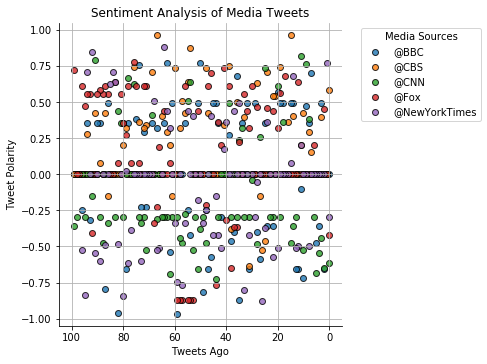

In [6]:

sns.lmplot(x="Tweet_Ago", y="Compound", data=df, hue="User", fit_reg=False,  
           scatter_kws={ 'edgecolor':'black'}, legend=False);

plt.xlim(105,-5)
plt.ylim(-1.05,1.05)
plt.xlabel("Tweets Ago")
plt.ylabel("Tweet Polarity")
plt.legend(title="Media Sources", bbox_to_anchor=(1.05,1),loc=2)
plt.title("Sentiment Analysis of Media Tweets")
plt.grid()
plt.savefig("Output/SentimentAnalysisOfMediaTweets.png")

In [7]:
user_df = df.groupby('User')['Compound'].mean().reset_index()

In [8]:
user_df.columns = ["User","Polarity_mean"]
user_df

,User,Polarity_mean
0,@BBC,0.002077
1,@CBS,0.171889
2,@CNN,-0.096477
3,@Fox,0.131302
4,@NewYorkTimes,-0.068120


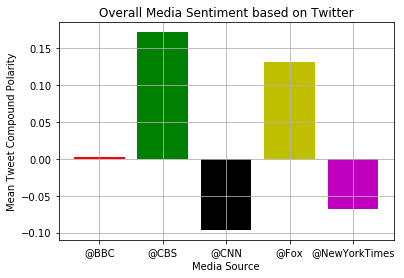

In [9]:
my_colors = 'rgkymcb'

plt.title('Overall Media Sentiment based on Twitter')
plt.ylabel('Mean Tweet Compound Polarity')
plt.xlabel('Media Source')
plt.grid()
plt.bar(user_df['User'],user_df['Polarity_mean'],color=my_colors);
plt.savefig("Output/OverAllSentimentMedia.png")